<font size="10">Prediction of Housing Prices</font>

<font size="5">Introduction</font>

Due to the large growth of the urban population, housing resources seem to be relatively inadequate (Jiang & Qiu, 2022). Therefore, studying trends in housing prices has become a topic of great concern among economists and the government, due to the importance of real estate valuation on the general condition of the population's economic state (Heldak & Pluciennik, 2019). Given that accurate valuation of houses is needed by both renters and owners, it is vital to use prediction models based on the right characteristics. The factors that can influence the median housing price in a block include (not limited to): median income; the number of bedrooms; population; proximity to water bodies. Therefore we are going to predict what is the expected median house price (response variable) in a block in California based on certain values of those factors (explanatory variables), and determine the best subset of factor(s) that produce the most accurate prediction model. We will use the following "Housing" dataset https://www.kaggle.com/datasets/camnugent/california-housing-prices. It contains information about 20640 blocks in California with their median house price, along with 10 descriptive variables.

<font size="5">Analysis Question</font>

**What is the best regression model to predict the median house price of a block given the aforementioned set of characteristics?**

<font size="5">Data Loading and Processing</font>

We begin by loading essential R libraries for data manipulation, visualization, and modeling. 

In [2]:
library(glmnet)
library(tidyverse)
library(broom)
library(repr)
library(mltools)
library(leaps)
library(car)
library(GGally)
library(fastDummies)
library(corrplot)

The dataset, "housing 3.csv", contains detailed information about housing in California, including the location (latitude and longitude), median age of the houses, total rooms, bedrooms, population, and more. Initial exploration with functions like head() and glimpse() provides us with a preliminary understanding of the data structure and the types of variables present.

In [3]:
data = read.csv("housing 3.csv")

In [4]:
head(data)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
2,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
3,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
4,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
5,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
6,-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


In [5]:
glimpse(data)

Rows: 20,640
Columns: 10
$ longitude          <dbl> -122.23, -122.22, -122.24, -122.25, -122.25, -122.2…
$ latitude           <dbl> 37.88, 37.86, 37.85, 37.85, 37.85, 37.85, 37.84, 37…
$ housing_median_age <dbl> 41, 21, 52, 52, 52, 52, 52, 52, 42, 52, 52, 52, 52,…
$ total_rooms        <dbl> 880, 7099, 1467, 1274, 1627, 919, 2535, 3104, 2555,…
$ total_bedrooms     <dbl> 129, 1106, 190, 235, 280, 213, 489, 687, 665, 707, …
$ population         <dbl> 322, 2401, 496, 558, 565, 413, 1094, 1157, 1206, 15…
$ households         <dbl> 126, 1138, 177, 219, 259, 193, 514, 647, 595, 714, …
$ median_income      <dbl> 8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6…
$ median_house_value <dbl> 452600, 358500, 352100, 341300, 342200, 269700, 299…
$ ocean_proximity    <chr> "NEAR BAY", "NEAR BAY", "NEAR BAY", "NEAR BAY", "NE…


In the preprocessing phase, rows with missing values were removed from the housing dataset to ensure data integrity, and a new feature, rooms_household, was calculated as the ratio of total rooms to households.

In [6]:
data = na.omit(data)

In [7]:
data$rooms_household <- data$total_rooms / data$households

<font size="5">Exploratory Data Analysis (EDA)</font>

Our primary goal in the EDA is to visually explore how different predictor variables, such as median income, geographical location, house age, and proximity to the ocean, among others, correlate with the median house value. By examining these relationships, we aim to understand better which features play a pivotal role in determining house prices.

We first take a look at how median income of the block affects median house value.

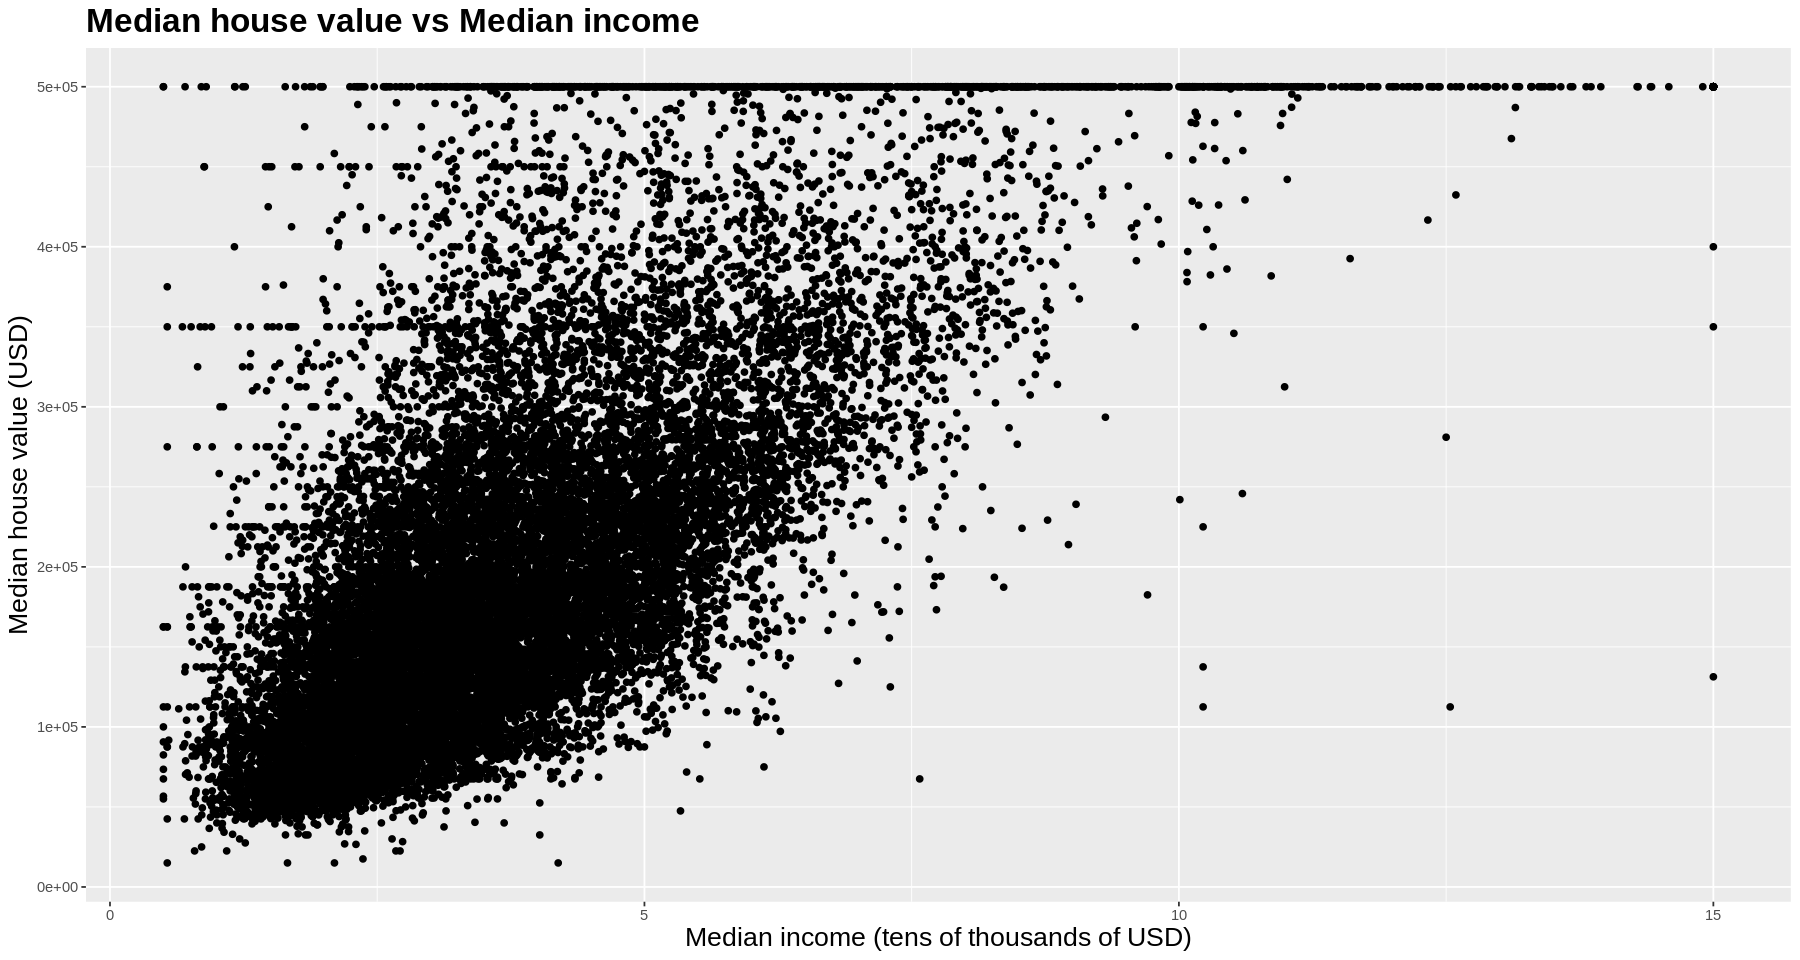

In [8]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data, aes(x = median_income, y = median_house_value)) +
  geom_point() +  
  labs(x = "Median income (tens of thousands of USD)", y = "Median house value (USD)") + 
  ggtitle("Median house value vs Median income") +
  theme(
    plot.title = element_text(size = 20, face = "bold"), 
    axis.title.x = element_text(size = 16), 
    axis.title.y = element_text(size = 16))



The median income of the block shows a stong positive correlation with the median house value.

We now look at how median house value differs based on different levels of ocean proximity.

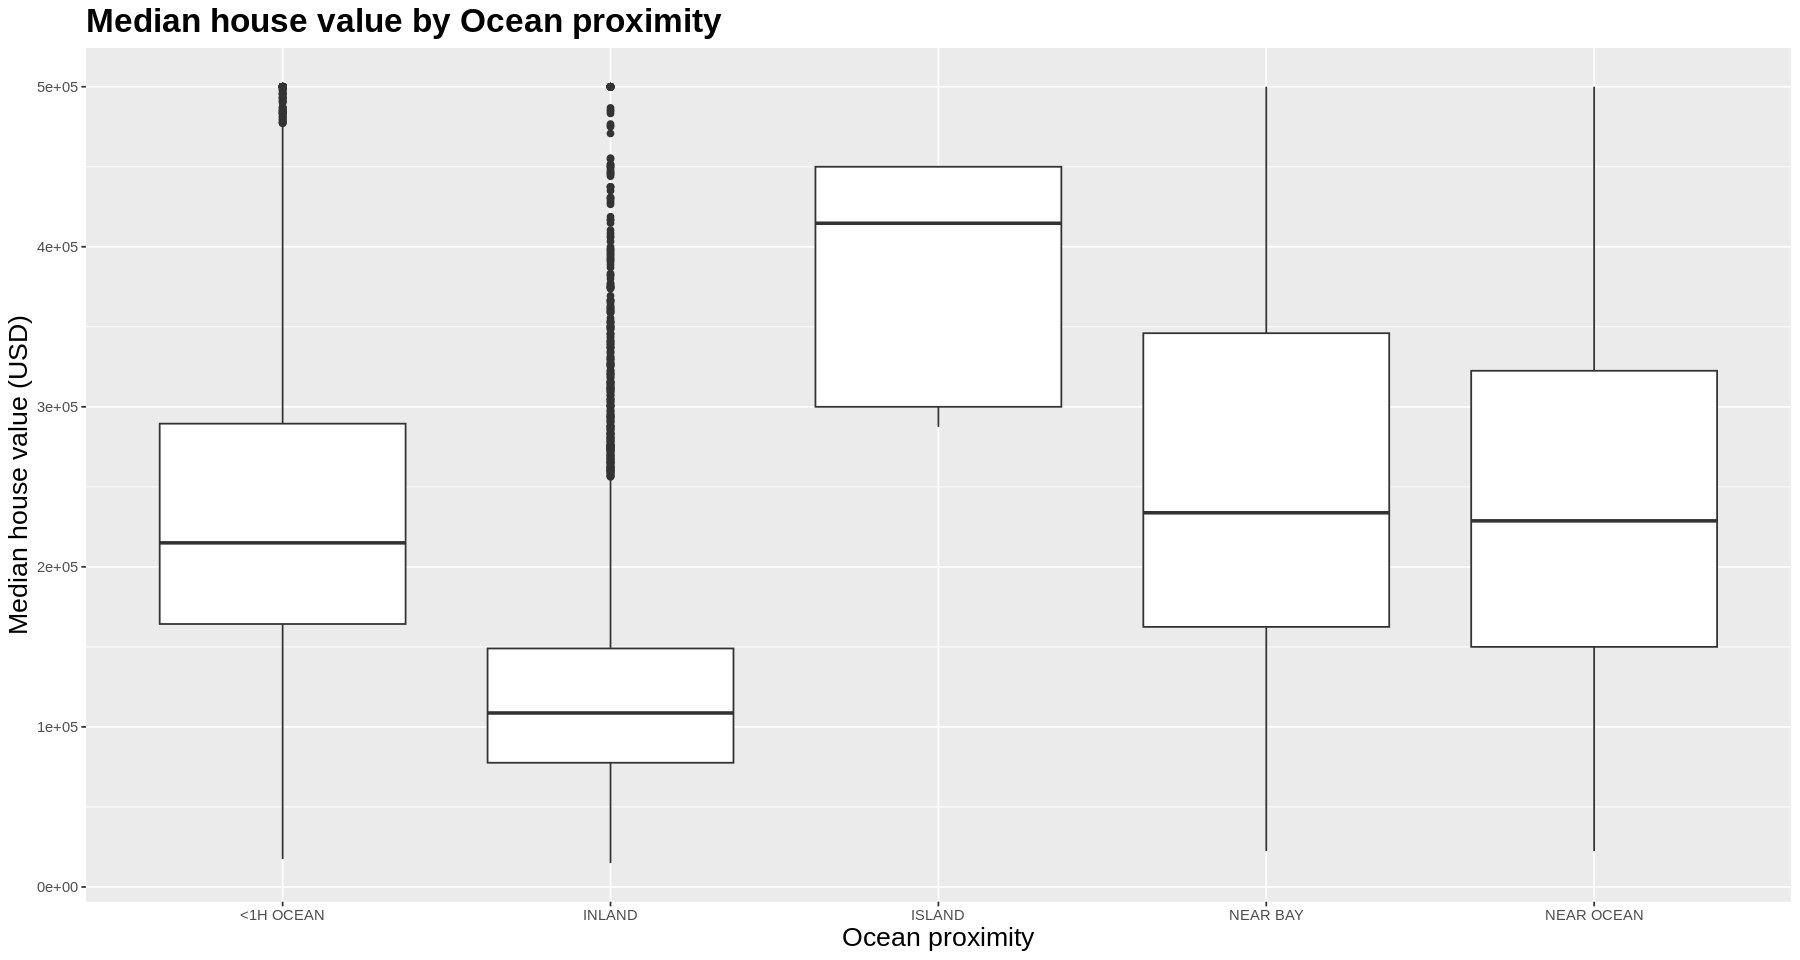

In [9]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data, aes(x = ocean_proximity, y = median_house_value)) +
  geom_boxplot() +
  labs(x = "Ocean proximity", y = "Median house value (USD)") +
  ggtitle("Median house value by Ocean proximity") +
  theme(
    plot.title = element_text(size = 20, face = "bold"), 
    axis.title.x = element_text(size = 16), 
    axis.title.y = element_text(size = 16))

There appears to be differences in median house value based on Ocean proximity. Average median house value is the highest in Islands followed by close proximity to water bodies and then Inland. This can clearly be seen in the table below.

In [10]:
mean_values <-  summarise(group_by(data, ocean_proximity), `Mean value` = mean(median_house_value, na.rm = TRUE))
mean_values

ocean_proximity,Mean value
<chr>,<dbl>
<1H OCEAN,240268.0
INLAND,124896.9
ISLAND,380440.0
NEAR BAY,259279.3
NEAR OCEAN,249042.4


Finally, we plot the geographical map of the California region and colour the locations by median house value to see how the median house value differs based on location.

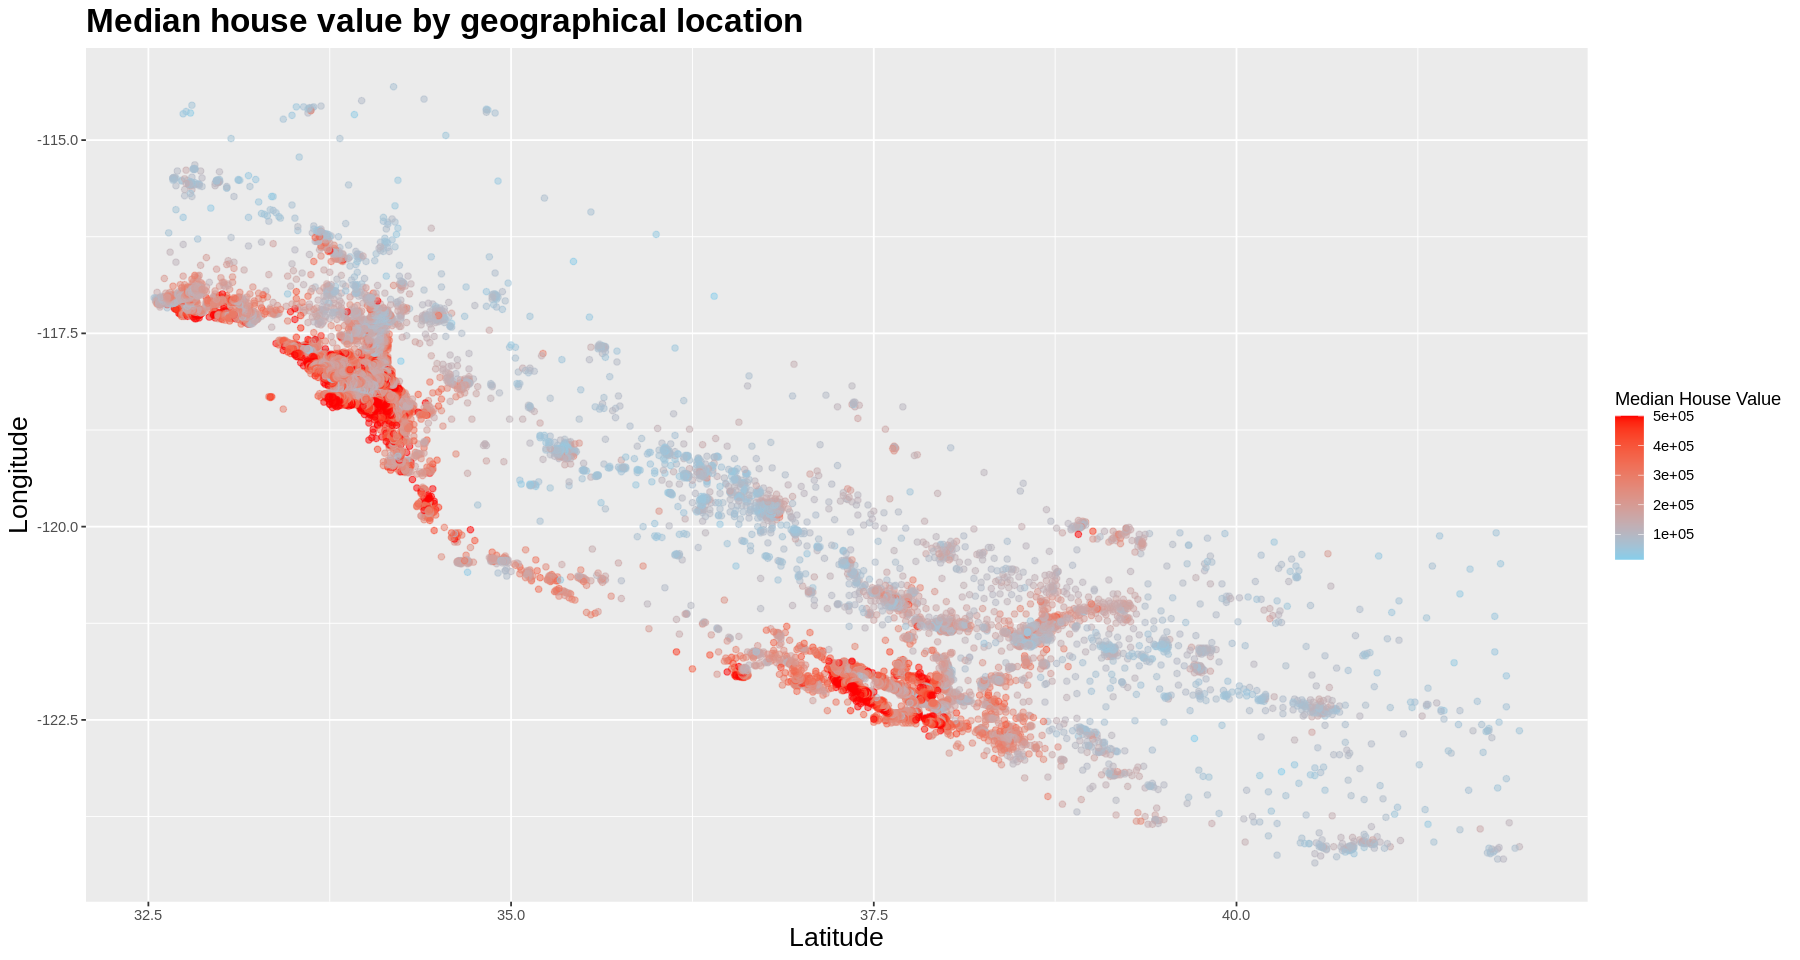

In [11]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data, aes(x = latitude, y = longitude, color = median_house_value)) +
  geom_point(alpha = 0.5) +  
  scale_color_gradient(low = "skyblue", high = "red") +  
  labs(x = "Latitude", y = "Longitude", color = "Median House Value") +
  ggtitle("Median house value by geographical location") +
  theme(
    plot.title = element_text(size = 20, face = "bold"), 
    axis.title.x = element_text(size = 16), 
    axis.title.y = element_text(size = 16))

The median house value is highist near the coast and decreases as we move Inland. This aligns with our previous results based on ocean proximity.

<font size="5">Model Assumptions</font>

*Normality Assumption*

In regression modeling, adherence to the normality assumption for predictor variables enhances the reliability of parameter estimates and significance tests. We plot the predictors to check if they follow the normality assumption.

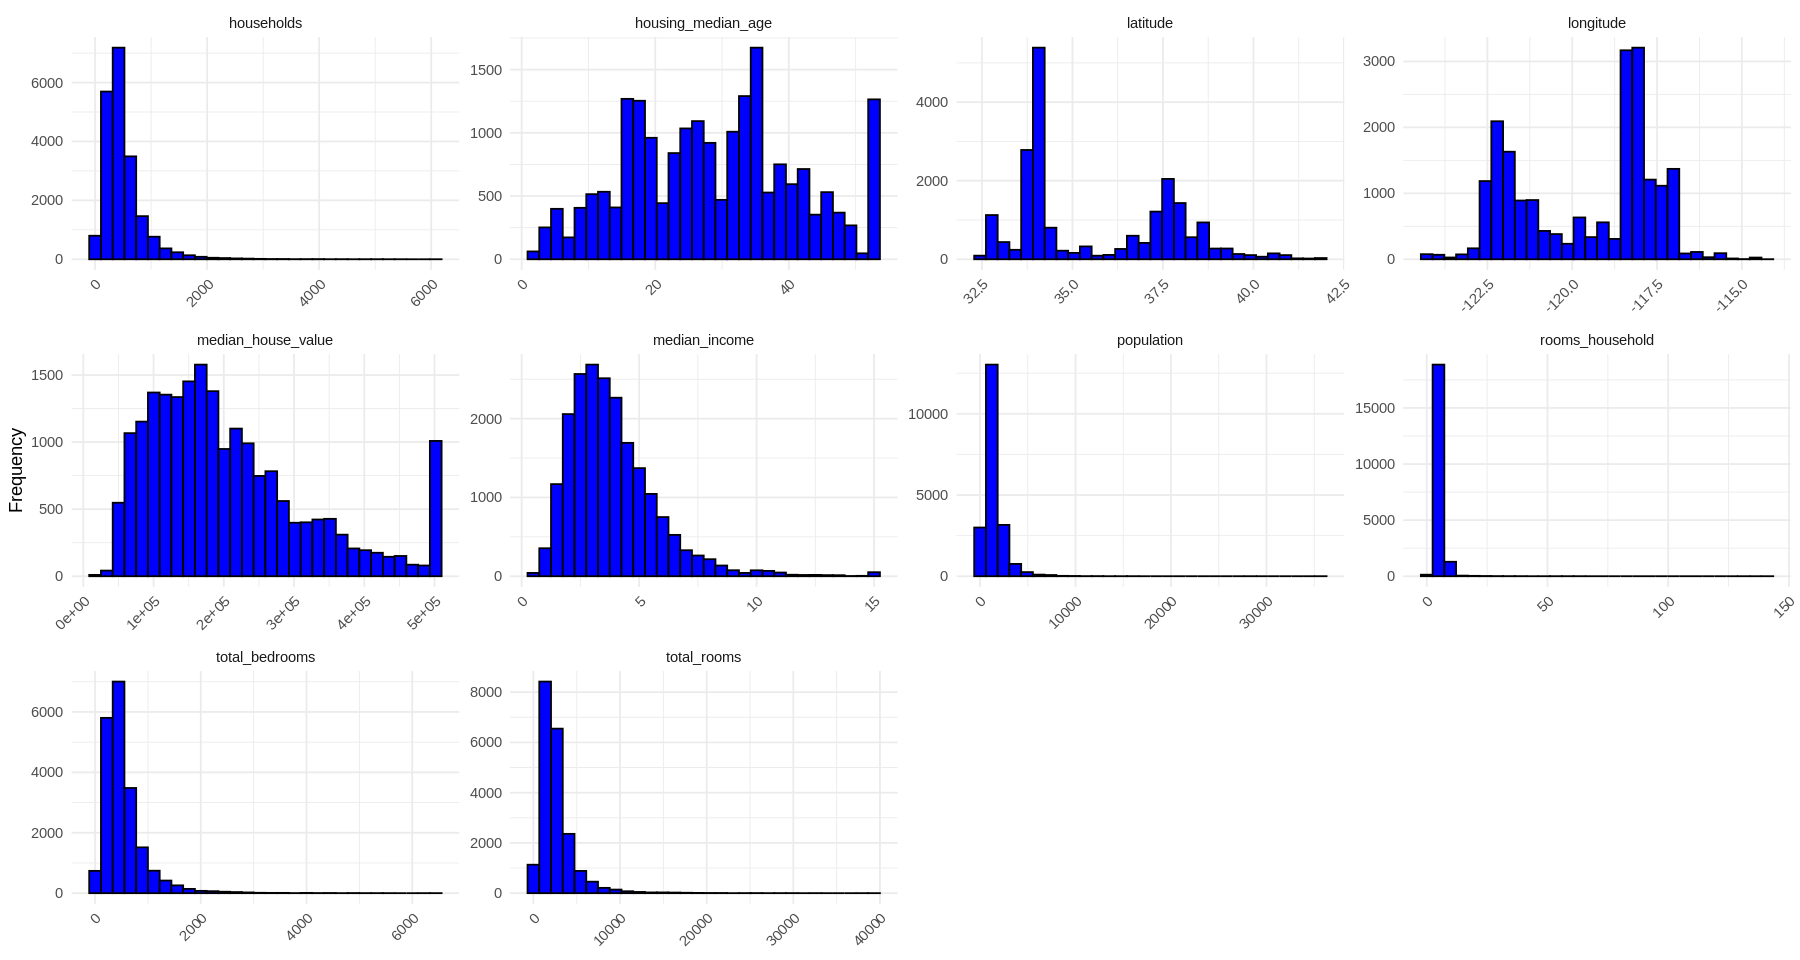

In [12]:
numeric_data_long = pivot_longer(select(data, where(is.numeric)), cols = everything(), names_to = "Variable", values_to = "Value")
ggplot(numeric_data_long, aes(x = Value)) + 
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ Variable, scales = "free") +
  theme_minimal() +
  labs(x = NULL, y = "Frequency") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

To address deviations from this assumption, particularly skewed distributions, we apply logarithmic transformations to skewed predictors, thereby approximating normality and optimizing the model's performance. 

In [13]:
data = mutate(data,
    total_rooms = log(total_rooms + 1),
    total_bedrooms = log(total_bedrooms + 1),
    population = log(population + 1),
    households = log(households + 1),
    rooms_household = log(rooms_household + 1))

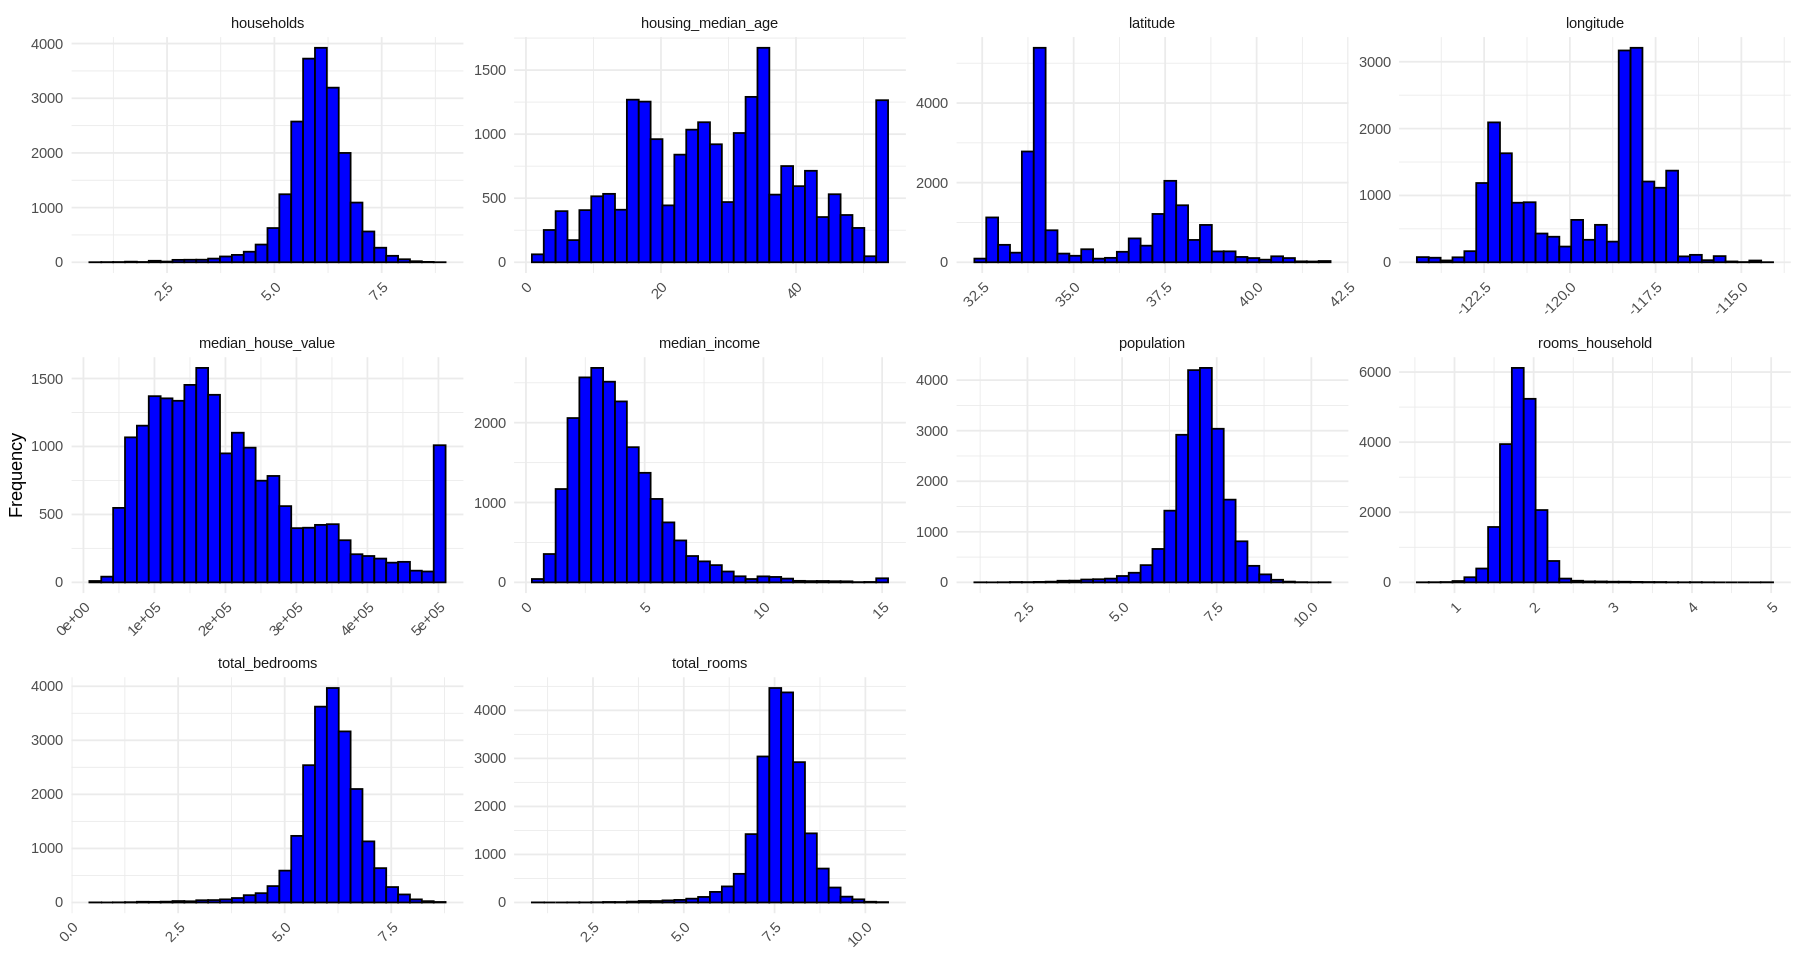

In [14]:
numeric_data_long2 = pivot_longer(select(data, where(is.numeric)), cols = everything(), names_to = "Variable", values_to = "Value")
ggplot(numeric_data_long2, aes(x = Value)) + 
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ Variable, scales = "free") +
  theme_minimal() +
  labs(x = NULL, y = "Frequency") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

The predictor variables are now approximately normal.

*Multicollinearity*

Multicollinearity occurs when predictor variables in a regression model are highly correlated, potentially undermining the reliability of the model's coefficient estimates. To mitigate this issue, we evaluate the degree of multicollinearity through Variance Inflation Factor (VIF) and remove highly correlated predictors, thereby stabilizing the model's estimates.

We perform a correlation analysis to identify potentially multicollinear variables, which could affect model performance. 

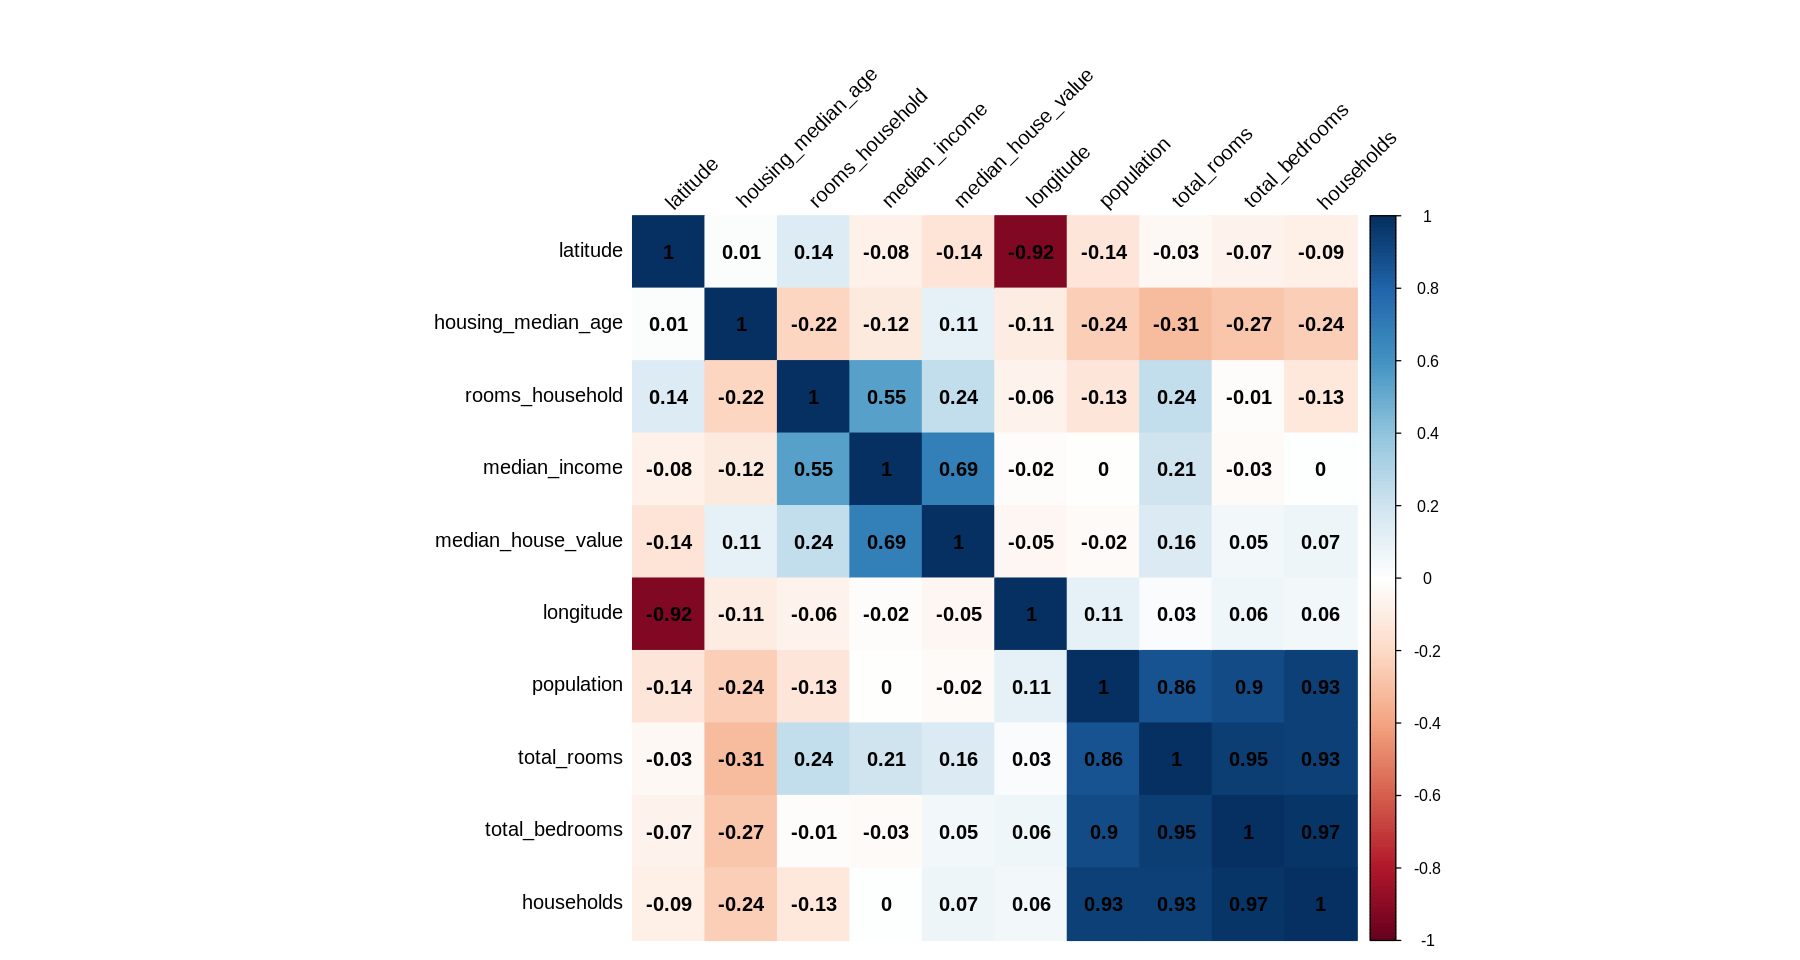

In [15]:
options(repr.plot.width=15, repr.plot.height=8)
cor_matrix <- cor(data[, sapply(data, is.numeric)])  
corrplot(cor_matrix, method = "color", order = "hclust",
         addCoef.col = "black", tl.col = "black", tl.srt = 45) 

We can see that some of our predictor variables are highly correlated with each other, for example households and population, raising possible concerns of multicollinearity.

We calculate the Variance Inflation Factor (VIF) for each predictor to quantify multicollinearity. 

In [16]:
vif(lm(median_house_value ~ ., data = data))

,GVIF,Df,GVIF^(1/(2*Df))
longitude,18.622870,1,4.315422
latitude,20.762686,1,4.556609
housing_median_age,1.296838,1,1.138788
total_rooms,2705.570451,1,52.015098
total_bedrooms,58.105079,1,7.622669
population,8.356116,1,2.890695
households,3090.213564,1,55.589689
median_income,2.881180,1,1.697404
ocean_proximity,4.250048,4,1.198255
rooms_household,391.527815,1,19.787062


Based on VIF values, we decide to remove variables with high multicollinearity, such as latitude, longitude, total rooms, and households, to improve model accuracy and interpretation.

In [17]:
data <- subset(data, select = -c(latitude, longitude, total_rooms, households))

In [18]:
vif(lm(median_house_value ~ ., data = data))

,GVIF,Df,GVIF^(1/(2*Df))
housing_median_age,1.278324,1,1.130630
total_bedrooms,5.973744,1,2.444124
population,6.059447,1,2.461594
median_income,1.872268,1,1.368308
ocean_proximity,1.472897,4,1.049595
rooms_household,1.956831,1,1.398868


The VIF scores of all predictors are now stable and not inflated.

<font size="5">Model Evaluation and Selection</font>

We begin by one-hot encoding the categorical levels of ocean proximity column into individual binary columns. This is done because feature selection algorithms like forward selection and LASSO do not work well with categorical predictors with multiple levels.

In [19]:
ocean_proximity_counts <- count(data, ocean_proximity)
print(ocean_proximity_counts)

  ocean_proximity    n
1       <1H OCEAN 9034
2          INLAND 6496
3          ISLAND    5
4        NEAR BAY 2270
5      NEAR OCEAN 2628


In [20]:
data <- fastDummies::dummy_cols(data, select_columns = "ocean_proximity", remove_selected_columns = TRUE)

Our project aims to build three types of models:

- A full additive regression model including all predictors. 
- A reduced model selected through forward selection, optimizing for predictors that contribute most significantly to the outcome.
- A LASSO regression model to enforce regularization, automatically selecting important features and shrinking coefficients of less important ones.
   
We will then compare their performance using RMSE to evaluate the best model.

Since predictive models are built and trained to predict new observations, We first divide the data into two datasets: a training set (70% of the data in the training_housing dataset) and a test set (30% of the data in the testing_housing dataset).

In [21]:
set.seed(321) #for reproducibility

data$ID <- rownames(data)
training_housing <- sample_n(
    data, 
    size = nrow(data) * 0.70,
    replace = FALSE)
 
testing_housing <- anti_join(
    data, 
    training_housing, 
    by = "ID")

training_housing <- select(training_housing, -"ID")
testing_housing <- select(testing_housing, -"ID")

head(training_housing)
nrow(training_housing)

head(testing_housing)
nrow(testing_housing)

,housing_median_age,total_bedrooms,population,median_income,median_house_value,rooms_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,52,6.431331,7.080868,2.3887,337500,1.626882,0,0,0,1,0
2,30,7.034388,7.847372,3.5817,369300,1.788807,0,0,0,0,1
3,14,6.448889,7.170888,2.6023,221100,1.564943,1,0,0,0,0
4,32,6.391917,8.157944,2.7250,450000,1.944823,0,0,0,0,1
5,34,5.968708,7.174724,4.0379,172800,1.836711,1,0,0,0,0
6,23,6.315358,6.905753,3.6620,211900,1.611096,1,0,0,0,0


[1] 14303

,housing_median_age,total_bedrooms,population,median_income,median_house_value,rooms_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,41,4.867534,5.777652,8.3252,452600,2.077455,0,0,0,1,0
2,52,6.194405,6.998510,3.6591,299200,1.780346,0,0,0,1,0
3,52,6.562444,7.347300,3.6912,261100,1.786845,0,0,0,1,0
4,52,6.163315,7.002156,3.0750,213500,1.844138,0,0,0,1,0
5,50,6.122493,6.898715,1.9911,158700,1.847458,0,0,0,1,0
6,42,5.908083,6.835185,1.7135,159800,1.700766,0,0,0,1,0


[1] 6130

Focusing on the training_housing dataset, we estimate a full additive MLR and obtain the out-of-sample predictions from the test set by using the predict() function.

In [22]:
housing_full_add <- lm(median_house_value ~ .,
    data = training_housing)

housing_test_pred_full_add <- predict(housing_full_add,
    newdata = testing_housing[, -5])

head(housing_test_pred_full_add)

1        2        3        4        5        6 
418616.1 263848.2 269299.2 229624.1 183503.5 157090.1

Now, we select a smaller subset of variables by using the forward selection algorithm

Using regsubsets() function to perform the forward selection, we construct a tibble 'housing_fwd_summary_df' that stores different evaluation metrics including RSS, BIC, and Cp from the best models chosen by forward selection for each n (number of predictors).

In [23]:
housing_forward_sel <- regsubsets(
    x = median_house_value ~ ., 
    nvmax = 9,
    data = training_housing,
    method = "forward")

housing_fwd_summary <- summary(housing_forward_sel)

housing_fwd_summary_df <- tibble(
    n_input_variables = 1:9,
    RSS = housing_fwd_summary$rss,
    BIC = housing_fwd_summary$bic,
    Cp = housing_fwd_summary$cp)

housing_fwd_summary_df
summary(housing_forward_sel)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“1  linear dependencies found”


n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,9.920103e+13,-9265.963,7966.068244
2,7.817853e+13,-12662.702,3249.696394
3,7.595656e+13,-13065.539,2752.988479
4,7.421491e+13,-13387.750,2364.085911
5,6.607259e+13,-15040.349,538.591951
6,6.391183e+13,-15506.349,55.622013
7,6.378403e+13,-15525.410,28.937863
8,6.367745e+13,-15539.761,7.016896
9,6.367737e+13,-15530.210,9.000000


Subset selection object
Call: regsubsets.formula(x = median_house_value ~ ., nvmax = 9, data = training_housing, 
    method = "forward")
10 Variables  (and intercept)
                             Forced in Forced out
housing_median_age               FALSE      FALSE
total_bedrooms                   FALSE      FALSE
population                       FALSE      FALSE
median_income                    FALSE      FALSE
rooms_household                  FALSE      FALSE
`ocean_proximity_<1H OCEAN`      FALSE      FALSE
ocean_proximity_INLAND           FALSE      FALSE
ocean_proximity_ISLAND           FALSE      FALSE
`ocean_proximity_NEAR BAY`       FALSE      FALSE
`ocean_proximity_NEAR OCEAN`     FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         housing_median_age total_bedrooms population median_income
1  ( 1 ) " "                " "            " "        "*"          
2  ( 1 ) " "                " "            " "        "*"          
3  ( 1 ) "*"      

The Mallows's Cp values show a decreasing trend with more variables in the model (until 8 predictors), and the lowest Cp is 7.016896 with 8 input variables, which indicates that the model (with the 8 input variables) may be relatively precise (has small variance) in predicting future responses.

We then set a regression model by using the 8 input variables which are selected using forward selection, and predict the new data with this reduced model. 

RMSE of the full additive regression model and reduced regression model are computed from the test set to indicate which one has a better prediction performance.

In [24]:
housing_red <- lm(median_house_value ~ housing_median_age + total_bedrooms +
                   population + median_income + rooms_household + 
                   ocean_proximity_INLAND + ocean_proximity_ISLAND + 
                  `ocean_proximity_NEAR OCEAN`,
    data = training_housing)

housing_test_pred_red <- predict(housing_red, newdata = testing_housing[, -5])
head(housing_test_pred_red)

housing_R_MSE_models <- rbind(
    tibble(
        Model = "Full Additive Regression Model",
        R_MSE = rmse(
        preds = housing_test_pred_full_add,
        actuals = testing_housing$median_house_value)),
    tibble(
        Model = "Reduced Regression Model",
        R_MSE = rmse(
        preds = housing_test_pred_red,
        actuals = testing_housing$median_house_value)))

housing_R_MSE_models

1        2        3        4        5        6 
418795.5 264013.8 269463.5 229792.1 183673.8 157276.9

Model,R_MSE
<chr>,<dbl>
Full Additive Regression Model,70017.91
Reduced Regression Model,70017.34


RMSE (Root Mean Square Error) is a standard way to measure the error of a model in prediction. The Reduced regression Model has a smaller RMSE, which is 70017.34.  

Moving on, we compare the predictive performance of these models relative to a LASSO regression.

We use the cv.glmnet() function to find an optimal value of 𝜆, but glmnet requires matrices with input variables and a vector of responses, so I first convert 'training_housing' and 'testing_housing' into matrices.

A plot is made to visualize how the estimated test-MSE changes for different values of 𝜆s.

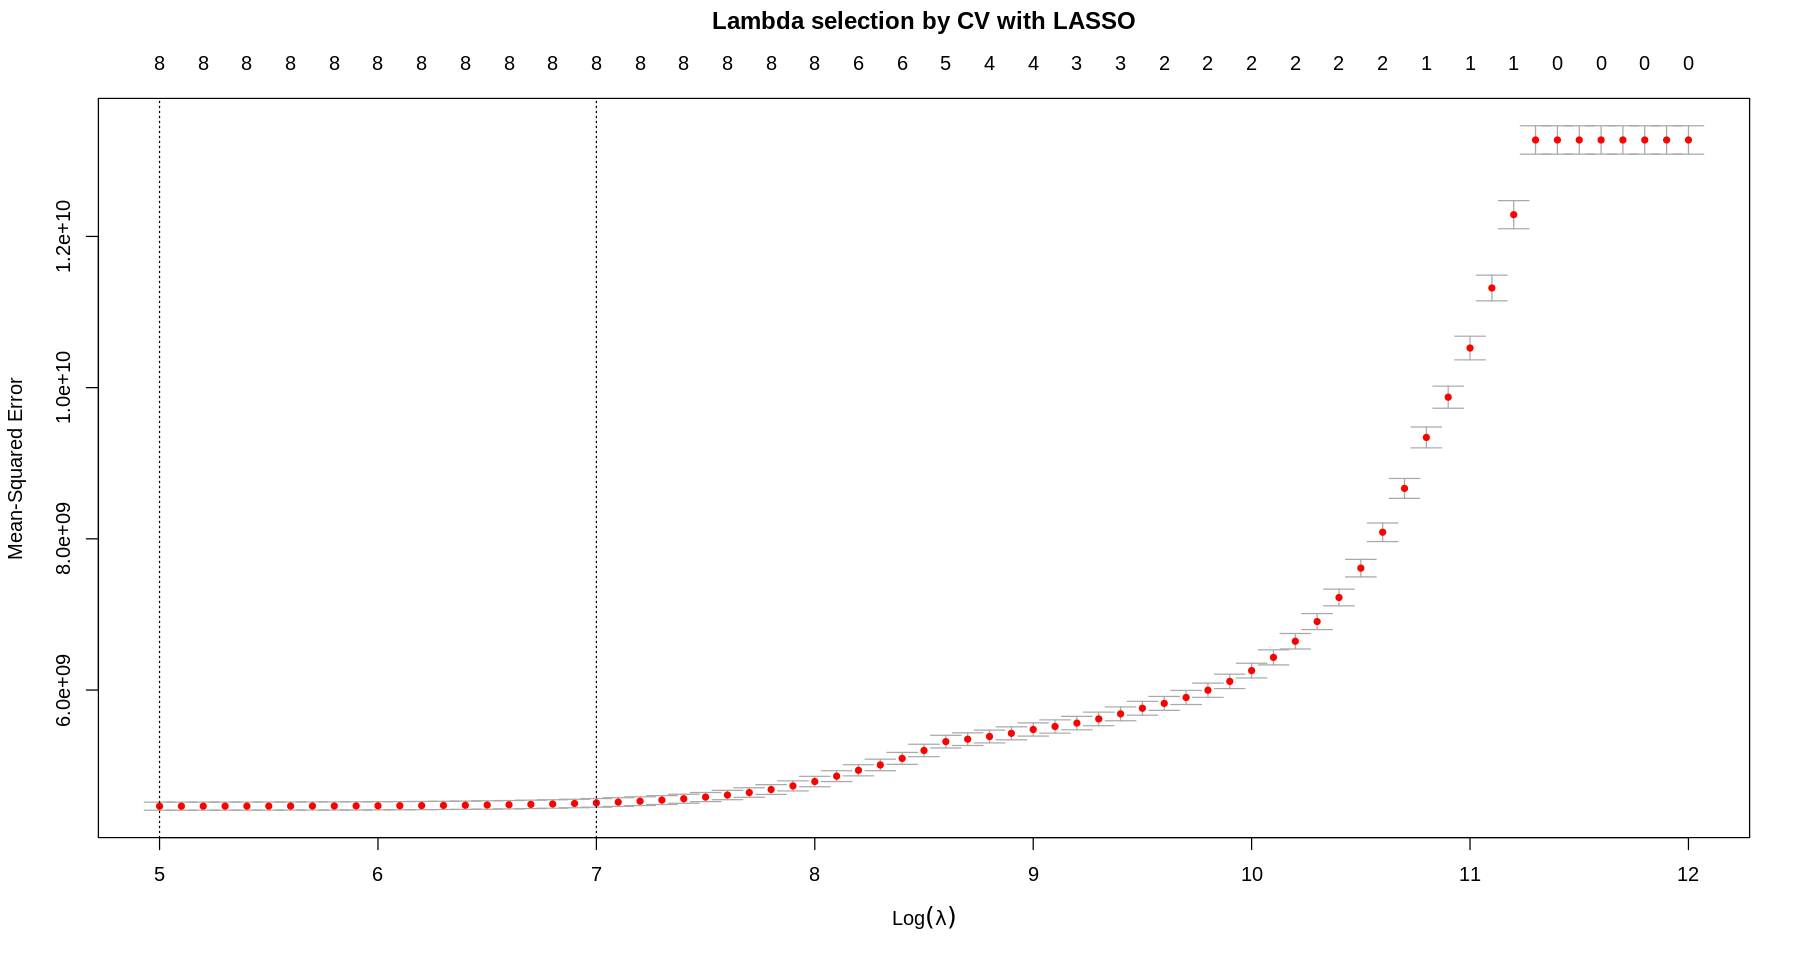

In [25]:
model_matrix_X_train <- model.matrix(
    object = median_house_value ~ .,
    data = training_housing)[, -1]

matrix_Y_train <- as.matrix(
    training_housing$median_house_value, 
    ncol = 1)

model_matrix_X_test <- model.matrix(
    object = median_house_value ~ .,
    data = testing_housing)[, -1]

matrix_Y_test <- as.matrix(
    testing_housing$median_house_value, 
    ncol = 1)

Housing_cv_lambda_LASSO <- cv.glmnet(
    x = model_matrix_X_train, 
    y = matrix_Y_train,
    alpha = 1,
    lambda = exp(seq(5, 12, 0.1)))

plot(Housing_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n")

In the plot, the two vertical dotted lines corresponding to two values of 𝜆: 𝜆̂ min (e^5=148.41) provide the minimum MSE in the grid. 𝜆̂ 1SE (around e^7) is the largest value of lambda such that the corresponding MSE is within 1 standard error of that of the minimum.

Then, we compute the lambda value with the least MSE, and visualize the estimated regression coefficients.

[1] 148.41

[1] 5

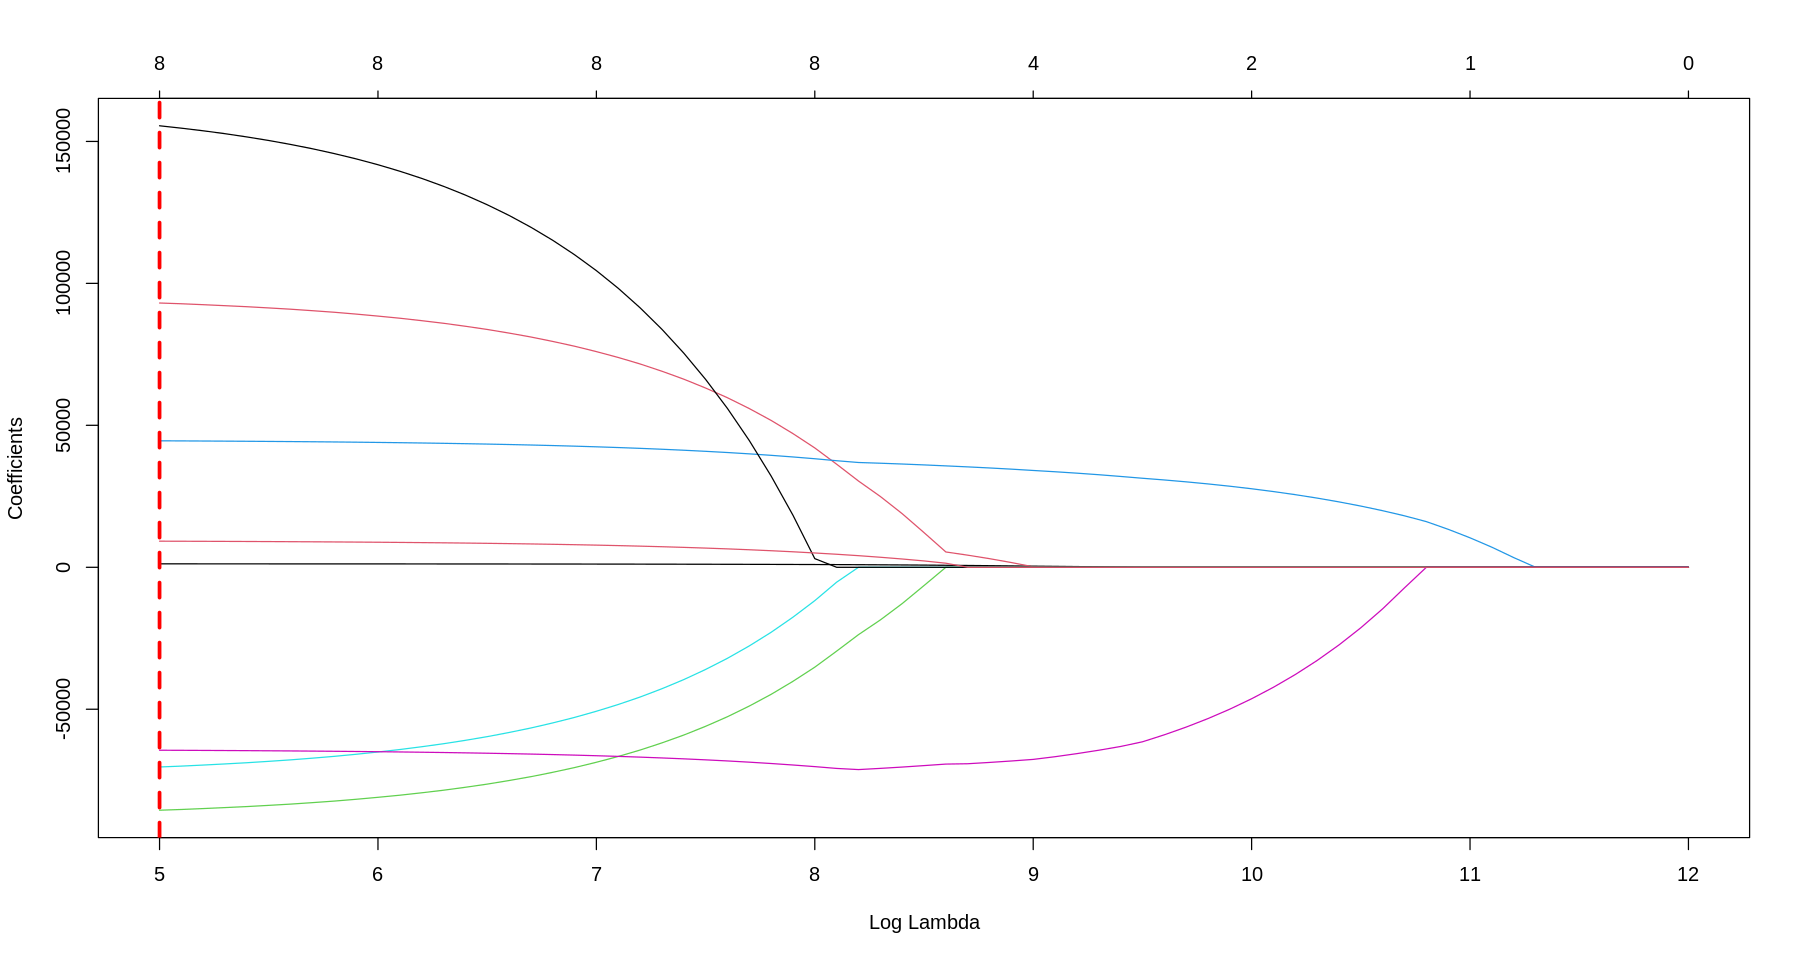

In [26]:
Housing_lambda_min_MSE_LASSO <- round(Housing_cv_lambda_LASSO$lambda.min, 4)
round(Housing_lambda_min_MSE_LASSO,2)
round(log(Housing_lambda_min_MSE_LASSO),2)

plot(Housing_cv_lambda_LASSO$glmnet.fit, "lambda")
abline(v = log(Housing_lambda_min_MSE_LASSO), col = "red", lwd = 3, lty = 2)

We set a LASSO model for minimum lambda and compare the coefficients of the selcted model with those of the full LS.

In [27]:
Housing_LASSO_min <- glmnet(
    x = model_matrix_X_train, 
    y = matrix_Y_train,
    alpha = 1,
    lambda = Housing_lambda_min_MSE_LASSO)

Housing_LASSO_min.coef <- Housing_LASSO_min$beta

Housing_reg_coef <- round(cbind(
    Full_OLS = coef(housing_full_add),
    LASSO_min = c(
    Housing_LASSO_min$a0,
    as.vector(Housing_LASSO_min.coef))), 4)

Housing_reg_coef

,Full_OLS,LASSO_min
(Intercept),200846.756,185331.848
housing_median_age,1221.898,1208.390
total_bedrooms,96013.417,93331.291
population,-88444.769,-85796.793
median_income,44895.289,44570.610
rooms_household,-73569.296,-70548.346
`ocean_proximity_<1H OCEAN`,-9348.238,0.000
ocean_proximity_INLAND,-73503.508,-64402.789
ocean_proximity_ISLAND,153975.182,155423.067
`ocean_proximity_NEAR BAY`,-9599.230,0.000


We finally predict the new data from the LASSO model and compute the RMSE of LASSO Regression for the futhur comparison with the previous two models.

In [28]:
Housing_test_pred_LASSO_min <- predict(
    Housing_LASSO_min,
    newx = model_matrix_X_test)

Housing_RMSE_models <- rbind(
    housing_R_MSE_models,
    tibble(
        Model = "LASSO Regression with minimum MSE",
        R_MSE = rmse(
        preds = Housing_test_pred_LASSO_min,
        actuals = testing_housing$median_house_value)))

Housing_RMSE_models

Model,R_MSE
<chr>,<dbl>
Full Additive Regression Model,70017.91
Reduced Regression Model,70017.34
LASSO Regression with minimum MSE,69983.56


The RMSE of the LASSO Regression model is 69983.56, which is the least among the 3 models, meaning the LASSO model has the best prediction performance!

<font size="5">Results</font>

We examined the variation in median house price of a block due to several descriptive variables like median income, ocean proximity and geographical coordinates using methods like boxplots and scatterplots. We saw that median house price of a  block increases with increae in median income and also depends on the geographical location and proximity to ocean. It is higher in blocks close to the ocean and near the coast.

We then investigate the regression model assumptions. Using correlation plots and GVIF, we find that some of our predictors are heavily correlated leading to multicollinearity among them. We remove the predictors with a very high GVIF and this helps solve the issue as the new scores of the selected variables are low.
We look at the distribution of predictors thrpoigh histograms and logarithmic transform the varibales that deviated from normaloty assumption .

We move onto fitting the linear model and computing the RSME for prediction accuracy. Next, we performed feature selection. By using forward selection algorithm, we compared the Cp values of best regression models of different number of predictors. We found that the Mallows's Cp values show a decreasing trend with more variables in the model, and the lowest Cp is 7.016896 with 8 input variables. Therefore we fit an OLS model using the chosen 8 variables. 

Finally, we fit a LASSO regression model, and used cross validation to choose the best lambda value (148.41), which minimizes MSE. Overall, we found that the RMSE of LASSO Regression (RMSE = 69983.56) is smaller than the RMSE of the other two models(Full Additive Regression Model RMSE: 70017.91 and Reduced Regression Model RMSE: 70017.34). 

<font size="5">References</font>

Heldak, M., & Pluciennik, M. (2019). Financing housing support programs in poland in the light of national housing resources. IOP Conference Series. Materials Science and Engineering, 471(11), 112031. https://doi.org/10.1088/1757-899X/471/11/112031

Jiang, Y., & Qiu, L. (2022). Empirical study on the influencing factors of housing price –––Based on cross-section data of 31 provinces and cities in china. Procedia Computer Science, 199, 1498-1504. https://doi.org/10.1016/j.procs.2022.01.191